# Gaussian Process Revenue Forecasting

This notebook implements and tests the Gaussian Process model for daily revenue forecasting, strictly following the specified kernel and feature engineering requirements.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Add project root to path to allow imports
project_root = os.path.abspath("../../../../")
if project_root not in sys.path:
    sys.path.append(project_root)

from src.core.db.connection import get_db_connection
from src.api.routers.forecast import get_historical_data
from src.core.learning.revenue_forecasting.gaussianprocess import (
    GaussianProcessForecaster, sample_data, add_lag_features, forecast_days
)

%matplotlib inline

/Users/kshitijsharma/Documents/projects/analytics/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Load Data
Fetching real data from the database. If insufficient data exists, falling back to sample data.

In [16]:
conn, _ = get_db_connection()

try:
    df = get_historical_data(conn, start_date="11-11-25", end_date="08-02-26")
    print(f"Loaded {len(df)} rows from database.")
except Exception as e:
    print(f"DB load failed: {e}")
    df = pd.DataFrame()
finally:
    conn.close()

# Fallback to sample data if DB is empty or too small for meaningful GP training
if len(df) < 30:
    print("Not enough real data. Generating synthetic sample data for demonstration.")
    df = sample_data(n=365)

print("Sample rows:")
display(df.tail())

Connecting to database at: /Users/kshitijsharma/Documents/projects/analytics/analytics.db
Loaded 90 rows from database.
Sample rows:


,ds,y,orders,temp_max,rain_sum,weather_code,forecast_snapshot
85,2026-02-04,30144.0,42,19.9,0.0,3,"{""time"": [""2026-02-04"", ""2026-02-05"", ""2026-02..."
86,2026-02-05,27135.0,50,20.8,0.0,1,"{""time"": [""2026-02-05"", ""2026-02-06"", ""2026-02..."
87,2026-02-06,31987.0,54,22.2,0.0,0,"{""time"": [""2026-02-06"", ""2026-02-07"", ""2026-02..."
88,2026-02-07,60555.0,85,22.8,0.0,3,"{""time"": [""2026-02-07"", ""2026-02-08"", ""2026-02..."
89,2026-02-08,53857.0,79,21.8,0.0,3,"{""time"": [""2026-02-08"", ""2026-02-09"", ""2026-02..."


## 2. Train Gaussian Process Model
Initializing the model with the mandatory kernel structure and fitting it to the data.

In [17]:
# KEEP ORIGINAL SAFE
df_raw = df.copy()

# Training data uses lag features
train_df = add_lag_features(df_raw)

forecaster = GaussianProcessForecaster()

print("Training GP Model... (this may take a moment)")
forecaster.fit(train_df, target='y')
print("Training Complete.")

Training GP Model... (this may take a moment)
Training Complete.


## 3. Evaluation
Compute MAE, RMSE, and 95% coverage.

In [18]:
# ---- Lag helpers ----

def add_lag_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['lag1'] = df['y'].shift(1)
    df['lag7'] = df['y'].shift(7)
    return df.dropna(subset=['lag1','lag7']).reset_index(drop=True)


def make_next_row(date, temp, history):
    if len(history) < 7:
        raise ValueError("Need at least 7 historical points for lag7")

    lag1 = history.iloc[-1]['y']
    lag7 = history.iloc[-7]['y']

    return pd.DataFrame({
        'ds': [pd.Timestamp(date)],
        'temp_max': [temp],
        'lag1': [lag1],
        'lag7': [lag7]
    })


def append_prediction(history, date, pred_mean):
    return pd.concat([
        history,
        pd.DataFrame({'ds':[pd.Timestamp(date)], 'y':[float(pred_mean)]})
    ], ignore_index=True)


def walk_forward_test(model, raw_df, min_history=30):
    preds = []
    actuals = []
    stds = []

    for i in range(min_history, len(raw_df)):

        history = raw_df.iloc[:i].copy()

        # build lagged history (must have >=7 rows AFTER lagging)
        hist_lagged = add_lag_features(history)

        if len(hist_lagged) < 7:
            continue

        next_day = raw_df.iloc[i]

        row = make_next_row(
            next_day['ds'],
            next_day['temp_max'],
            hist_lagged[['ds','y']]
        )

        mean, std = model.predict(row)

        preds.append(mean[0])
        stds.append(std[0])
        actuals.append(next_day['y'])

    preds = np.array(preds)
    stds = np.array(stds)
    actuals = np.array(actuals)

    if len(preds) == 0:
        print("No valid predictions generated — dataset too small")
        return

    mae = np.mean(np.abs(preds - actuals))
    rmse = np.sqrt(np.mean((preds - actuals)**2))
    coverage = np.mean((actuals >= preds-1.96*stds) & (actuals <= preds+1.96*stds))

    print(f"WalkForward MAE={mae:.2f} RMSE={rmse:.2f} Coverage95={coverage:.2%}")

In [19]:
walk_forward_test(forecaster, df_raw)

WalkForward MAE=4116.39 RMSE=5121.65 Coverage95=100.00%


In [20]:
# 4. Recursive Forecast (7-day ahead)
# Get stored weather forecast from last day's snapshot
import json
last_snapshot = json.loads(df.iloc[-1]['forecast_snapshot'])
future_weather = pd.DataFrame({
    'ds': pd.to_datetime(last_snapshot['time'][:7]),
    'temp_max': last_snapshot['temperature_2m_max'][:7]
})

# Use recursive forecaster (NEVER call predict() directly for future dates)
forecast = forecast_days(forecaster, df_raw, future_weather)
print(forecast)

          ds     pred_mean      pred_std         lower         upper
0 2026-02-08  46555.974965  14057.541745  19003.193146  74108.756785
1 2026-02-09  24251.962736   8372.357899   7842.141254  40661.784218
2 2026-02-10  29020.030933   9750.212451   9909.614528  48130.447337
3 2026-02-11  28621.327145   9996.225609   9028.724951  48213.929340
4 2026-02-12  31553.342130  11237.067068   9528.690677  53577.993583
5 2026-02-13  29009.925241  10306.777348   8808.641638  49211.208844
6 2026-02-14  41672.216786  14741.850285  12778.190228  70566.243344


In [21]:
last_snapshot

{'time': ['2026-02-08',
  '2026-02-09',
  '2026-02-10',
  '2026-02-11',
  '2026-02-12',
  '2026-02-13',
  '2026-02-14'],
 'temperature_2m_max': [22.7, 22.6, 23.6, 24.0, 22.7, 22.9, 24.9],
 'temperature_2m_min': [8.9, 9.2, 10.5, 11.5, 8.4, 8.7, 9.0],
 'precipitation_sum': [0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0],
 'weather_code': [45, 3, 2, 45, 1, 3, 2]}

## 4. Visualization
Plotting actuals vs predictions with uncertainty intervals.

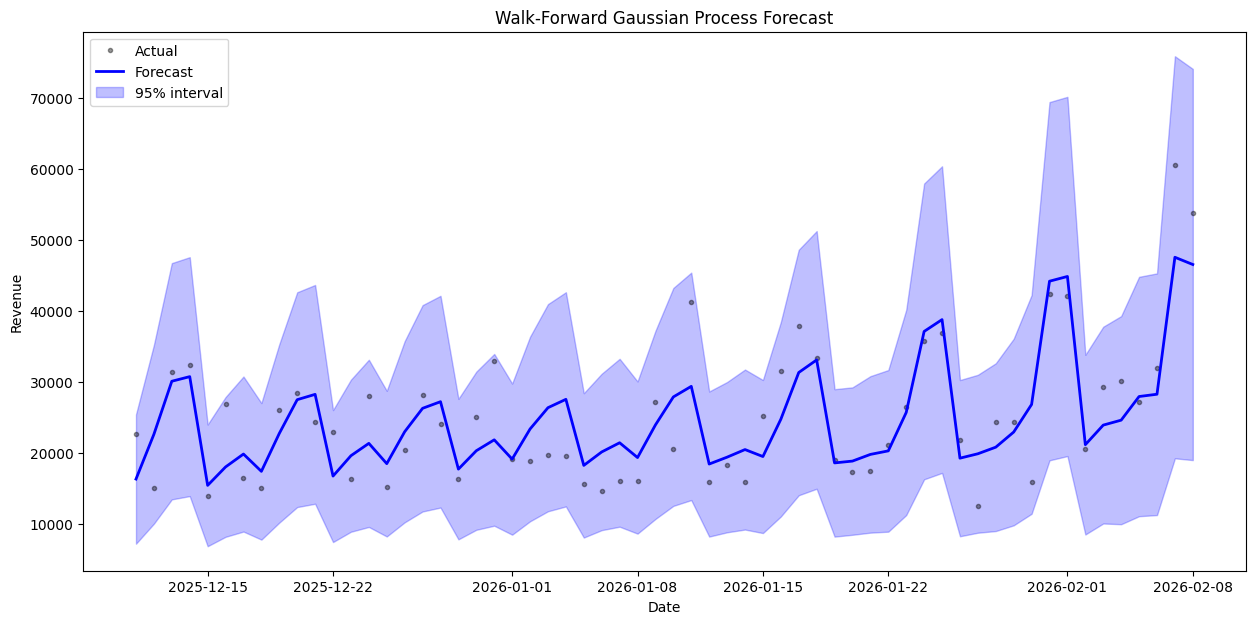

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def rolling_predict_series(model, raw_df, min_history=30):
    """
    Walk-forward reconstruction of historical predictions.

    Returns a dataframe aligned with dates:
    columns = [ds, y, pred_mean, pred_std, lower, upper]
    """

    history = raw_df.iloc[:min_history].copy()
    records = []

    for i in range(min_history, len(raw_df)):
        next_day = raw_df.iloc[i]

        hist_lagged = add_lag_features(history)

        # Not enough past for lag7 → skip prediction
        if len(hist_lagged) < 7:
            history = pd.concat([history, raw_df.iloc[i:i+1]])
            continue

        row = make_next_row(
            next_day['ds'],
            next_day['temp_max'],
            hist_lagged[['ds', 'y']]
        )

        mean, std = model.predict(row)

        records.append({
            'ds': next_day['ds'],
            'y': next_day['y'],
            'pred_mean': float(mean[0]),
            'pred_std': float(std[0]),
            'lower': float(mean[0] - 1.96*std[0]),
            'upper': float(mean[0] + 1.96*std[0]),
        })

        # advance time with real observation
        history = pd.concat([history, raw_df.iloc[i:i+1]])

    return pd.DataFrame(records)

plot_df = rolling_predict_series(forecaster, df_raw)
plt.figure(figsize=(15,7))

plt.plot(plot_df['ds'], plot_df['y'], 'k.', alpha=0.4, label="Actual")
plt.plot(plot_df['ds'], plot_df['pred_mean'], 'b-', linewidth=2, label="Forecast")

plt.fill_between(
    plot_df['ds'],
    plot_df['lower'],
    plot_df['upper'],
    alpha=0.25,
    color='blue',
    label="95% interval"
)

plt.title("Walk-Forward Gaussian Process Forecast")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.show()

## 5. Scenario Predictions
Testing specific scenarios as required:
- Hot Summer Saturday
- Cold Winter Monday

In [7]:
print("Learned Kernel:", forecaster.model.kernel_)
print("\nInterpretation:")
print("- RBF Component (dim=2): Captures the smooth, non-linear relationship between temperature and revenue.")
print("- ExpSineSquared (dim=0, Yearly): Captures broad annual seasonality (high in summer, low in winter).")
print("- ExpSineSquared (dim=1, Weekly): Captures the weekly cycle (weekend peaks vs weekday lulls).")
print("- WhiteKernel: Captures random noise/day-to-day variance not explained by calendar or weather.")

Learned Kernel: 0.816**2 * RBF(length_scale=[1.7, 0.313, 0.719, 2.29, 100]) + WhiteKernel(noise_level=0.5)

Interpretation:
- RBF Component (dim=2): Captures the smooth, non-linear relationship between temperature and revenue.
- ExpSineSquared (dim=0, Yearly): Captures broad annual seasonality (high in summer, low in winter).
- ExpSineSquared (dim=1, Weekly): Captures the weekly cycle (weekend peaks vs weekday lulls).
- WhiteKernel: Captures random noise/day-to-day variance not explained by calendar or weather.


## 7. Save Model (Optional)

In [8]:
# forecaster.save('gp_model.joblib')
# print('Model saved.')